# <center>Empirical IO Assignment 3</center>
## <center>Ian Jaeyeon Kim</center>

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from scipy.optimize import root
import statsmodels.api as sm
import time
import statsmodels.api as sm
import linearmodels
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
import pyblp
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

# Roadmap for Part2 (Q1, Q2, Q3)

* Conditional indirect utility of consumer $i$, $U_{ijt}(x_j, p_j, \xi_j; \alpha, \beta)$, is a function of x, satellite, wired, price with parameters `𝛼`, `𝛽(1)`, `𝛽(2)`, and, `𝛽(3)`.
* But, to generate fake dataset here we assume parameter values$(\alpha, \beta)$ and draw product related data$(x_j , \xi_j)$.
* Hence,  $U_{ijt}(\overline{x_j}, p_j, \overline{\xi_j}; \overline{\alpha}, \overline{\beta})$ becomes a function of price level. And thereafter $s_j(p)$ becomes a function of prices.
* Furthermore, since we exogenously put parameters $\gamma_0, \gamma_1$ to cost functions, first order conditions derived from the bertrand nash equilibrium are now reduced to a root finding problem with respect to prices. 
* Hence, using root finding algorithm(or fixed point algorithm) we can <b>find market prices</b> under the given parametric assumptions and data generating process. 
* Subsequently, using the derived market prices we can <b>derive observed market shares</b>. 

# Q1. Draw x, w, xi, omega

In [119]:
# define exogenously given parameters
𝛼 = -2 
𝛽_1 = 1
𝛾_0 = 1/2
𝛾_1 = 1/4

In [3]:
# Draw x, w
x_1 = abs(np.random.standard_normal(600))
x_2 = abs(np.random.standard_normal(600))
x_3 = abs(np.random.standard_normal(600))
x_4 = abs(np.random.standard_normal(600))
x = np.array([x_1, x_2, x_3, x_4])

w_1 = abs(np.random.standard_normal(600))
w_2 = abs(np.random.standard_normal(600))
w_3 = abs(np.random.standard_normal(600))
w_4 = abs(np.random.standard_normal(600))
w = np.array([w_1, w_2, w_3, w_4])

In [4]:
# Draw xi, omega
cov = np.array([[1, 0.25],
                [0.25,1]])
A = np.linalg.cholesky(cov)

def xi_omega_draw():
    xi = []
    omega = []
    temp_xi = np.random.standard_normal(600)
    temp_omega = np.random.standard_normal(600)
    for i in range(600):
        temp_z = np.array([[temp_xi[i]],[temp_omega[i]]])
        result = A@temp_z
        xi.append(result[0][0])
        omega.append(result[1][0])
    return xi, omega
1
xi_1, omega_1 = xi_omega_draw()
xi_2, omega_2 = xi_omega_draw()
xi_3, omega_3 = xi_omega_draw()
xi_4, omega_4 = xi_omega_draw()
xi = np.array([xi_1, xi_2, xi_3, xi_4])
omega = np.array([omega_1, omega_2, omega_3, omega_4])

In [5]:
# Draw beta w/ different size of N = 100, 500, 1000, 3000
beta2_100  = np.random.normal(4, 1, 100) 
beta2_500  = np.random.normal(4, 1, 500) 
beta2_1000 = np.random.normal(4, 1, 1000) 
beta2_3000 = np.random.normal(4, 1, 3000) 

beta3_100  = np.random.normal(4, 1, 100) 
beta3_500  = np.random.normal(4, 1, 500) 
beta3_1000 = np.random.normal(4, 1, 1000) 
beta3_3000 = np.random.normal(4, 1, 3000) 

# Q2. Solve for the Eqm Prices for each good, in each market

## Step (a) 

Since,
$$ s_{jt} = \int\int \frac{exp(\beta^{(1)}x_{jt} + \beta_i^{(2)}satellite_{jt} + \beta_i^{(3)}wired_{jt} - 2p_{jt} + \xi_{jt})}{\sum_{k\in\{0,\cdots, 4\}}exp(\beta^{(1)}x_{kt} + \beta_i^{(2)}satellite_{kt} + \beta_i^{(3)}wired_{kt} - 2p_{kt} + \xi_{jt})}dF(\beta_i^{(2)})dF(\beta_i^{(3)}) $$

Letting
$$ Q_{jt} := exp(\beta^{(1)}x_{jt} + \beta_i^{(2)}satellite_{jt} + \beta_i^{(3)}wired_{jt} - 2p_{jt} + \xi_{jt}) \\
\sum_{t} := \sum_{k\in\{0,\cdots, 4\}}exp(\beta^{(1)}x_{kt} + \beta_i^{(2)}satellite_{kt} + \beta_i^{(3)}wired_{kt} - 2p_{kt}+ \xi_{jt})
$$

By the Leibniz Integral Rule, we have 
$$\frac{\partial s_{jt}}{\partial p_{jt}} = \int\int \frac{2Q_{jt}^2 - 2Q_{jt}\sum_t}{(\sum_t)^2}dF(\beta_i^{(2)})dF(\beta_i^{(3)})  \\
\frac{\partial s_{jt}}{\partial p_{kt}} = \int\int \frac{2Q_{jt}Q_{kt}}{(\sum_t)^2}dF(\beta_i^{(2)})dF(\beta_i^{(3)})
$$



In [6]:
def s_jt(j, t, p):
    '''
    input: j: 0~3 <-- product number
           t: 0~599 <-- market number
           p: list with len(p) = 4 <-- list of prices
    output:s_jt
    '''

    beta2 = beta2_1000  # change the sample size here
    beta3 = beta3_1000
    
    sigma_t = 1 + np.exp(𝛽_1*x[0][t] + beta2 - 2*p[0] + xi[0][t]) \
                + np.exp(𝛽_1*x[1][t] + beta2 - 2*p[1] + xi[1][t]) \
                + np.exp(𝛽_1*x[2][t] + beta3 - 2*p[2] + xi[2][t]) \
                + np.exp(𝛽_1*x[3][t] + beta3 - 2*p[3] + xi[3][t])
    
    if j == 0 or j == 1:
        Q_jt = np.exp(𝛽_1*x[j][t] + beta2 - 2*p[j] + xi[j][t])
        s_jt = (Q_jt/sigma_t).mean()        
    else: 
        Q_jt = np.exp(𝛽_1*x[j][t] + beta3 - 2*p[j] + xi[j][t])
        s_jt = (Q_jt/sigma_t).mean()
    return s_jt          

In [7]:
def mc_jt(j, t):
    return np.exp(𝛾_0 + 𝛾_1*w[j][t] + omega[j][t]/8)

In [8]:
def round_s_over_p(j, k, t, p):
    '''
    input: j, k --> product number btw 0~3
            t --> market number btw 0~599
            p --> list of price len(p) == 4 
            
    output: round s_j over round p_k
    '''
    
    beta2 = beta2_3000  # change the sample size here
    beta3 = beta3_3000
    
    sigma_t = 1 + np.exp(𝛽_1*x[0][t] + beta2 - 2*p[0] + xi[0][t]) \
                + np.exp(𝛽_1*x[1][t] + beta2 - 2*p[1] + xi[1][t]) \
                + np.exp(𝛽_1*x[2][t] + beta3 - 2*p[2] + xi[2][t]) \
                + np.exp(𝛽_1*x[3][t] + beta3 - 2*p[3] + xi[3][t]) 
    
    if j == k:
        if j == 0 or j == 1:
            Q_jt = np.exp(𝛽_1*x[j][t] + beta2 - 2*p[j] + xi[j][t])
            round_s_over_p = ((2*Q_jt**2 - 2*Q_jt*sigma_t)/sigma_t**2).mean()
        else:
            Q_jt = np.exp(𝛽_1*x[j][t] + beta3 - 2*p[j] + xi[j][t])
            round_s_over_p = ((2*Q_jt**2 - 2*Q_jt*sigma_t)/sigma_t**2).mean()
            
    else:
        if j == 0 or j == 1:
            if k == 0 or k == 1:
                Q_jt = np.exp(𝛽_1*x[j][t] + beta2 - 2*p[j] + xi[j][t])
                Q_kt = np.exp(𝛽_1*x[k][t] + beta2 - 2*p[k] + xi[k][t])
                round_s_over_p = (2*Q_jt*Q_kt/sigma_t**2).mean()
            else:
                Q_jt = np.exp(𝛽_1*x[j][t] + beta2 - 2*p[j] + xi[j][t])
                Q_kt = np.exp(𝛽_1*x[k][t] + beta3 - 2*p[k] + xi[k][t])
                round_s_over_p = (2*Q_jt*Q_kt/sigma_t**2).mean()
        else:
            if k == 0 or k == 1:
                Q_jt = np.exp(𝛽_1*x[j][t] + beta3 - 2*p[j] + xi[j][t])
                Q_kt = np.exp(𝛽_1*x[k][t] + beta2 - 2*p[k] + xi[k][t])
                round_s_over_p = (2*Q_jt*Q_kt/sigma_t**2).mean()
            else:
                Q_jt = np.exp(𝛽_1*x[j][t] + beta3 - 2*p[j] + xi[j][t])
                Q_kt = np.exp(𝛽_1*x[k][t] + beta3 - 2*p[k] + xi[k][t])
                round_s_over_p = (2*Q_jt*Q_kt/sigma_t**2).mean()
    
    return round_s_over_p

## Step (b) and (c)

#### method (i)

In [9]:
market_price = []
for t in range(600):
    def sys_of_eqns(p):
        f = [p[0] - mc_jt(0, t) + s_jt(0, t, p)/round_s_over_p(0,0,t,p),
             p[1] - mc_jt(1, t) + s_jt(1, t, p)/round_s_over_p(1,1,t,p),
             p[2] - mc_jt(2, t) + s_jt(2, t, p)/round_s_over_p(2,2,t,p),
             p[3] - mc_jt(3, t) + s_jt(3, t, p)/round_s_over_p(3,3,t,p)]
        return f
    sol = root(sys_of_eqns, [3.1, 3.2, 3.3, 3.4])
    market_price.append(sol.x)

#### method (ii)

In [10]:
def lambda_t(t, p):
    lambda_matrix = np.array([[-2*s_jt(0,t,p),0,0,0],
                              [0,-2*s_jt(1,t,p),0,0],
                              [0,0,-2*s_jt(2,t,p),0],
                              [0,0,0,-2*s_jt(3,t,p)]])
    return lambda_matrix

In [11]:
def s_jtXs_kt(j,k,t,p):
    beta2 = beta2_100 
    beta3 = beta3_100
    
    sigma_t = 1 + np.exp(𝛽_1*x[0][t] + beta2 - 2*p[0] + xi[0][t]) \
                + np.exp(𝛽_1*x[1][t] + beta2 - 2*p[1] + xi[1][t]) \
                + np.exp(𝛽_1*x[2][t] + beta3 - 2*p[2] + xi[2][t]) \
                + np.exp(𝛽_1*x[3][t] + beta3 - 2*p[3] + xi[3][t])
    
    if j == 0 or j == 1:
        if k == 0 or k == 1:
            Q_jt = np.exp(𝛽_1*x[j][t] + beta2 - 2*p[j] + xi[j][t])
            Q_kt = np.exp(𝛽_1*x[k][t] + beta2 - 2*p[k] + xi[k][t])
            s_jtXs_kt = ((Q_jt/sigma_t)*(Q_kt/sigma_t)).mean()
        else:
            Q_jt = np.exp(𝛽_1*x[j][t] + beta2 - 2*p[j] + xi[j][t])
            Q_kt = np.exp(𝛽_1*x[k][t] + beta3 - 2*p[k] + xi[k][t])
            s_jtXs_kt = ((Q_jt/sigma_t)*(Q_kt/sigma_t)).mean()
    else:
        if k == 0 or k == 1:
            Q_jt = np.exp(𝛽_1*x[j][t] + beta3 - 2*p[j] + xi[j][t])
            Q_kt = np.exp(𝛽_1*x[k][t] + beta2 - 2*p[k] + xi[k][t])
            s_jtXs_kt = ((Q_jt/sigma_t)*(Q_kt/sigma_t)).mean()
        else:
            Q_jt = np.exp(𝛽_1*x[j][t] + beta3 - 2*p[j] + xi[j][t])
            Q_kt = np.exp(𝛽_1*x[k][t] + beta3 - 2*p[k] + xi[k][t])
            s_jtXs_kt = ((Q_jt/sigma_t)*(Q_kt/sigma_t)).mean()
    
    return s_jtXs_kt

In [12]:
def gamma_t(t,p):
    gamma_matrix = np.array([[-2*s_jtXs_kt(0,0,t,p), -2*s_jtXs_kt(0,1,t,p), -2*s_jtXs_kt(0,2,t,p), -2*s_jtXs_kt(0,3,t,p)],
                             [-2*s_jtXs_kt(1,0,t,p), -2*s_jtXs_kt(1,1,t,p), -2*s_jtXs_kt(1,2,t,p), -2*s_jtXs_kt(1,3,t,p)],
                             [-2*s_jtXs_kt(2,0,t,p), -2*s_jtXs_kt(2,1,t,p), -2*s_jtXs_kt(2,2,t,p), -2*s_jtXs_kt(2,3,t,p)],
                             [-2*s_jtXs_kt(3,0,t,p), -2*s_jtXs_kt(3,1,t,p), -2*s_jtXs_kt(3,2,t,p), -2*s_jtXs_kt(3,3,t,p)]])
    return gamma_matrix

In [13]:
market_price2 = []
for t in range(600):

    epsilon = 0.00001
    old_p = np.array([2.1,2.2,2.3,2.4])
    counter = 0
    while True:
        c = np.array([mc_jt(0,t), mc_jt(1,t), mc_jt(2,t), mc_jt(3,t)])
        lambda_matrix = lambda_t(t, old_p)
        H = np.identity(4)
        gamma_matrix = gamma_t(t, old_p)
        share = np.array([s_jt(0,t,old_p), s_jt(1,t,old_p), s_jt(2,t,old_p), s_jt(3,t,old_p)])
        new_p = c + np.linalg.inv(lambda_matrix)@np.multiply(H, gamma_matrix)@(old_p-c) - np.linalg.inv(lambda_matrix)@share

        dist = abs(new_p - old_p).max()
        if dist < epsilon:
            break
        else:
            old_p = 0.7*new_p + 0.3*old_p

    market_price2.append(new_p)

#### compare the result from (i) and (ii)

In [14]:
np.array(market_price) - np.array(market_price2)

array([[-0.00459903, -0.05032137,  0.08728314,  0.00949118],
       [-0.05209564, -0.03161557,  0.02210648,  0.06052367],
       [-0.03845409, -0.02228628,  0.00630214,  0.08767614],
       ...,
       [-0.08154682, -0.02990624,  0.06938191,  0.0106628 ],
       [-0.03634694, -0.01326335,  0.00190323,  0.11371752],
       [-0.11692524, -0.00696645,  0.03622952,  0.04275791]])

we can check that the results from (i) and (ii) are similar.

# Q3. Calculate Observed Shares

In [15]:
s_0 = []
s_1 = []
s_2 = []
s_3 = []
s_4 = []

for t in range(600):
    s_0.append(1-s_jt(0, t, market_price[t])-s_jt(1, t, market_price[t])-s_jt(2, t, market_price[t])-s_jt(3, t, market_price[t]))
    s_1.append(s_jt(0, t, market_price[t]))
    s_2.append(s_jt(1, t, market_price[t]))
    s_3.append(s_jt(2, t, market_price[t]))
    s_4.append(s_jt(3, t, market_price[t]))

observed_s = np.array([s_1, s_2, s_3, s_4])
# observed_s[0] --> share list of outer product
# observed_s[1] --> share list of product j 



----

# Roadmap for Part3 (Q4, Q5, Q6, Q7)

* From part1, we derived market prices and associated market shares of each products across 600 different markets.
* Keep using the generated data of x, we will estimate parameters $\alpha$ and $\beta$.
* Although we generated data for $\xi_j$ above, we won't use it in our specifications below because those are unobservable factors to econometricians. 
* Omitted $\xi_j$ will reveal the price variables to the endogeneity issue, since $\xi_j$ and $\omega_j$ are correlated by construction.
* To deal with the endogeneity problem from $\xi_j$, we will use instruments. 

# Q4 & Q5. Estimate the plain multinomial logit model

since
$$\frac{s_{jt}}{s_{0t}} = Q_{jt}$$
we have
$$\ln s_{jt} - \ln s_{0t} = \ln Q_{jt} \\
\Rightarrow \ln s_{jt} - \ln s_{0t} = \beta^{(1)}x_{jt} + \beta^{(2)}satellite_{jt} + \beta^{(3)}wired_{jt} + \alpha p_{jt} + \underbrace{\xi_{jt} + \epsilon_{jt}}_\text{error term} \quad \cdots (*)
$$
In Q4, we are required to do a simple OLS using the specification $(*)$.

## Data Preparation (Also Prepare for the Nested Logit)

In [16]:
price_1 = [i[0] for i in market_price2]
price_2 = [i[1] for i in market_price2]
price_3 = [i[2] for i in market_price2]
price_4 = [i[3] for i in market_price2]

In [17]:
cost_1 = [mc_jt(0, t) for t in range(600)]
cost_2 = [mc_jt(1, t) for t in range(600)]
cost_3 = [mc_jt(2, t) for t in range(600)]
cost_4 = [mc_jt(3, t) for t in range(600)]

In [18]:
t = [i for i in range(600)]
index_1 = [1 for i in range(600)]
index_2 = [2 for i in range(600)]
index_3 = [3 for i in range(600)]
index_4 = [4 for i in range(600)]

In [19]:
within_group_share_1 = np.array(s_1)/(np.array(s_1)+np.array(s_2))
within_group_share_2 = np.array(s_2)/(np.array(s_1)+np.array(s_2))
within_group_share_3 = np.array(s_3)/(np.array(s_3)+np.array(s_4))
within_group_share_4 = np.array(s_4)/(np.array(s_3)+np.array(s_4))

In [20]:
nested_IV_1 = x_2
nested_IV_2 = x_1
nested_IV_3 = x_4
nested_IV_4 = x_3

In [21]:
data_product_1 = df({'j': index_1,
                     't': t,
                     'price': price_1,
                     'cost' : cost_1,
                     'x': x_1,
                     'x_others': x_2+x_3+x_4,
                     'w': w_1,
                     'xi': xi_1,
                     'nested_IV': nested_IV_1,
                     'share': s_1,
                     'within_group_share': within_group_share_1,
                     'outside_share': s_0})

data_product_2 = df({'j': index_2,
                     't': t,
                     'price': price_2,
                     'cost' : cost_2,
                     'x': x_2,
                     'x_others': x_1+x_3+x_4,
                     'w': w_2,
                     'xi': xi_2,
                     'nested_IV': nested_IV_2,
                     'share': s_2,
                     'within_group_share': within_group_share_2,
                     'outside_share': s_0})

data_product_3 = df({'j': index_3,
                     't': t,
                     'price': price_3,
                     'cost' : cost_3,
                     'x': x_3,
                     'x_others': x_1+x_2+x_4,
                     'w': w_3,
                     'xi': xi_3,
                     'nested_IV': nested_IV_3,
                     'share': s_3,
                     'within_group_share': within_group_share_3,
                     'outside_share': s_0})

data_product_4 = df({'j': index_4,
                     't': t,
                     'price': price_4,
                     'cost' : cost_4,
                     'x': x_4,
                     'x_others': x_1+x_2+x_3,
                     'w': w_4,
                     'xi': xi_4,
                     'nested_IV': nested_IV_4,
                     'share': s_4,
                     'within_group_share': within_group_share_4,
                     'outside_share': s_0})

master = data_product_1
master = master.append(data_product_2)
master = master.append(data_product_3)
master = master.append(data_product_4)


In [22]:
master['satellite'] = np.where(master['j'] <= 2, 1, 0)
master['wired'] = np.where(master['j'] >= 3, 1, 0)
master['logged_group_share'] = np.log(master['within_group_share'])
master['dependent_var'] = np.log(master['share']) - np.log(master['outside_share'])
master['x_sums'] = master['x'] + master['x_others']
master.to_stata("master_from_python.dta")

## Regression 

# Q4. OLS

## Plain Multinomial Result: OLS

In [24]:
my_var = ['x', 'satellite', 'wired', 'price']
plain_result = sm.OLS(master['dependent_var'], master[my_var]).fit()
plain_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          dependent_var   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     334.3
Date:                Sun, 23 Oct 2022   Prob (F-statistic):          2.70e-181
Time:                        18:51:35   Log-Likelihood:                -3067.8
No. Observations:                2400   AIC:                             6144.
Df Residuals:                    2396   BIC:                             6167.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.8082      0.030     27.301      0.000       0.750       0.866
satellite      1.3164      0.127     10.392      0.000       1.068       1.565
wired          1.2683      0.124     10.197      0.000       1.024       1.512
price         -0.9304      0.046    -20.352      0.000      -1.020      -0.841
==============================================================================
Omnibus:                       50.115   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.806
Skew:                          -0.335   Prob(JB):                     2.07e-12
Kurtosis:                       3.299   Cond. No.                         30.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Q5. 2SLS

## Plain Multinomial Result: 2SLS

In [25]:
plain_result_IV_xw = IV2SLS(dependent=master['dependent_var'],
                                  exog=master[['x', 'satellite', 'wired']],
                                  endog=master['price'],
                                  instruments=master[['x_others','w']]).fit(cov_type='unadjusted')

In [26]:
plain_result_IV_xw

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          dependent_var   R-squared:                      0.1388
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1377
No. Observations:                2400   F-statistic:                    2192.6
Date:                Sun, Oct 23 2022   P-value (F-stat)                0.0000
Time:                        18:51:35   Distribution:                  chi2(4)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
x              0.9220     0.0332     27.807     0.0000      0.8570      0.9870
satellite      4.1251     0.1954     21.111     0.0000      3.7421      4.5080
wired          4.0265     0.1919     20.985     0.0000      3.6504      4.4025
price         -1.9839     0.0719    -27.599     0.0000     -2.1248     -1.8430
==============================================================================

Endogenous: price
Instruments: x_others, w
Unadjusted Covariance (Homoskedastic)
Debiased: False
IVResults, id: 0x7fe1ab7fdfa0

* Compared to the OLS result from Q4, we can check that the estimates after instrumenting price become more accurate in the sense that the values of the esimates become closer to the true paramters.
* Estimate for $\alpha$ is underestimated under the OLS result because of the contemporaneous factor $\xi_j$. 

# Q6. Nested Logit Model

* Before jumping on to the regression, justification for nested specification is needed.
* To work with nested logit specification, we need eviedence for grouping products. 
    * For example, we can comprare correlation of market shares (across markets) of product 1 and 2 to that of product 3 and 4.
    * If the distance between product 1 and 2 are more closer compared to 1 and 3 or 1 and 4, there will be a coupling between the market share of product 1 and 2
    
* Specification for the nested logit model is,  

$$\ln s_{jt} - \ln s_{0t} = \beta^{(1)}x_{jt} + \beta^{(2)}satellite_{jt} + \beta^{(3)}wired_{jt} + \alpha p_{jt} + \sigma^{satellite}\ln (s_{jt}/satellite) + \sigma^{wired}\ln (s_{jt}/wired) + \xi_{jt} \quad \cdots (**)
$$

* To estimate the heterogenous $sigma$ across two different nests. First, I tried the following SUR specification. 


$$\begin{bmatrix} 
\ln s_1 - \ln s_0 \\
\ln s_2 - \ln s_0 \\
\ln s_3 - \ln s_0 \\ 
\ln s_4 - \ln s_0 \\ 
\end{bmatrix}  = \begin{bmatrix}
\beta_1 & 0 & 0 & 0 \\
0 & \beta_2 & 0 & 0 \\
0 & 0 & \beta_3 & 0 \\
0 & 0 & 0 & \beta_4
\end{bmatrix}\begin{bmatrix} 
x_1 \\
x_2 \\
x_3 \\ 
x_4 \\ 
\end{bmatrix} + 
\begin{bmatrix}
\alpha_1 & 0 & 0 & 0 \\
0 & \alpha_2 & 0 & 0 \\
0 & 0 & \alpha_3 & 0 \\
0 & 0 & 0 & \alpha_4
\end{bmatrix}
\begin{bmatrix} 
P_1 \\
P_2 \\
P_3 \\ 
P_4 \\ 
\end{bmatrix} + 
\begin{bmatrix}
\sigma_1 & 0 & 0 & 0 \\
0 & \sigma_2 & 0 & 0 \\
0 & 0 & \sigma_3 & 0 \\
0 & 0 & 0 & \sigma_4
\end{bmatrix}
\begin{bmatrix} 
\ln(s_1/satellite)\\
\ln(s_2/satellite)\\
\ln(s_3/wired)\\
\ln(s_4/wired)\\
\end{bmatrix} + \xi
$$

* With imposing the following constraints:  
$$ \beta_1 = \beta_2 = \beta_3 = \beta_4 \\  
\alpha_1 = \alpha_2 = \alpha_3 = \alpha_4 \\
\sigma_1 = \sigma_2 \\
\sigma_3 = \sigma_4
$$

* And the price level is instrumented with the exogenous cost shift, which is $w_i$.  

* Within group share is instumented with characteristics of the other firm in the group, which is $x_{-j/gt}$.


<img src="https://github.com/Ian-JY-Kim/IO_coursework/blob/main/stata_nested_code.png?raw=true" width = "800" height ="500"></img>

<img src="https://github.com/Ian-JY-Kim/IO_coursework/blob/main/stata_nested_result.png?raw=true" width = "500" height ="400"></img>

* It turns out that the estimates under the nested logit specification are not similar to the true parameter values even after instrumenting the price variables and within group shares.

# Q7. Own-Price Elasticities & Diversion Ratio

* True own-price elasticity comes from the following,  

$$\frac{p_j}{s_j}\cdot\frac{\partial s_j}{\partial p_j} = -\frac{p_j}{p_j-mc_j}\quad \because \frac{\partial s_j}{\partial p_j} = -\frac{s_j}{p_j-mc_j}$$

* Using the chain rule, own-price elasticity can be estimated by the following,  

$$\frac{p_j}{s_j}\cdot\frac{\partial s_j}{\partial p_j} = \frac{p_j}{s_j}\cdot\frac{\partial s_j}{\partial \delta_j}\cdot\frac{\partial \delta_j}{\partial p_j}  \\
where \quad \frac{\partial s_j}{\partial \delta_j} = {\frac{1}{1-\sigma_g}s_j[1-\sigma_g s_{j/g} - (1-\sigma_g)s_j]}$$

* But from the estimated parameters, we have 
$$\sigma_{satellite} = \sigma_{wired} \simeq 0, \\ 
\frac{\partial \delta_j}{\partial p_j} = -1.767
$$  

* Hence, estimated own price elasticity becomes,
$$p_j \cdot (1-s_j) \cdot (-1.767)
$$

In [140]:
master['true_price_elasticity'] = -master['price']/(master['price'] - master['cost'])
master['estimated_elasticity'] = -1.767 * (1-np.array(master['share'])) * np.array(master['price'])
master['difference'] = np.abs(np.array(master['true_price_elasticity'])-np.array(master['estimated_elasticity'])) 
print("True and Estimated Own-Price Elasticities Under Nested Logit Specification")
master[['true_price_elasticity', 'estimated_elasticity', 'difference']]

True and Estimated Own-Price Elasticities Under Nested Logit Specification


,true_price_elasticity,estimated_elasticity,difference
0,-6.728905,-6.084411,0.644493
1,-2.947563,-3.049377,0.101815
2,-3.829131,-3.943013,0.113882
3,-5.260461,-4.999840,0.260620
4,-3.673104,-3.660481,0.012623
...,...,...,...
595,-2.914013,-2.673875,0.240138
596,-6.290404,-5.604897,0.685507
597,-6.518484,-5.778435,0.740049
598,-2.875246,-2.827144,0.048102


In [141]:
print("Average True Price Elasticity: ", np.array(master['true_price_elasticity']).mean())
print("Average Estimated Price Elasticity: ", np.array(master['estimated_elasticity']).mean())

Average True Price Elasticity:  -4.176652340847776
Average Estimated Price Elasticity:  -3.944297918275037


* Recall the formula of diversion ratio:
$$D_{jk}(p_j,p_{-j}) = \frac{\partial s_k / \partial p_j}{\left| \partial s_j/ \partial p_j \right|}
$$

In [132]:
def diversion_ratio_true(j,k,t):
    numerator = round_s_over_p(k,j,t,market_price2[t])
    denominator = -round_s_over_p(j,j,t,market_price2[t])
    return numerator/denominator

def diversion_ratio_observed(j,k,t):
    numerator = round_s_over_p(k,j,t,market_price2[t])
    denominator = observed_s[j][t]*(1-observed_s[j][t])*(1.767)
    return numerator/denominator


### True Diversion Ratio Matrix

In [139]:
base = np.array([[0,0,0,0],
                 [0,0,0,0],
                 [0,0,0,0],
                 [0,0,0,0]])
for t in range(600):
    temp = np.array([[diversion_ratio_true(0,0,t), diversion_ratio_true(0,1,t), diversion_ratio_true(0,2,t), diversion_ratio_true(0,3,t)],
                    [diversion_ratio_true(1,0,t), diversion_ratio_true(1,1,t), diversion_ratio_true(1,2,t), diversion_ratio_true(1,3,t)],
                    [diversion_ratio_true(2,0,t), diversion_ratio_true(2,1,t), diversion_ratio_true(2,2,t), diversion_ratio_true(2,3,t)],
                    [diversion_ratio_true(3,0,t), diversion_ratio_true(3,1,t), diversion_ratio_true(3,2,t), diversion_ratio_true(3,3,t)]])
    base = base + temp

base/600

array([[-1.        ,  0.29483145,  0.18513189,  0.18841896],
       [ 0.29509333, -1.        ,  0.18251279,  0.191185  ],
       [ 0.17100162,  0.16939952, -1.        ,  0.32909558],
       [ 0.17045607,  0.17405863,  0.32029782, -1.        ]])

### Estimated Diversion Ratio Matrix

In [31]:
base2 = np.array([[0,0,0,0],
                 [0,0,0,0],
                 [0,0,0,0],
                 [0,0,0,0]])
for t in range(600):
    temp = np.array([[diversion_ratio_observed(0,0,t), diversion_ratio_observed(0,1,t), diversion_ratio_observed(0,2,t), diversion_ratio_observed(0,3,t)],
                    [diversion_ratio_observed(1,0,t), diversion_ratio_observed(1,1,t), diversion_ratio_observed(1,2,t), diversion_ratio_observed(1,3,t)],
                    [diversion_ratio_observed(2,0,t), diversion_ratio_observed(2,1,t), diversion_ratio_observed(2,2,t), diversion_ratio_observed(2,3,t)],
                    [diversion_ratio_observed(3,0,t), diversion_ratio_observed(3,1,t), diversion_ratio_observed(3,2,t), diversion_ratio_observed(3,3,t)]])
    base2 = base2 + temp

base2/600

array([[-1.01151314,  0.3076037 ,  0.18349115,  0.18785181],
       [ 0.30710917, -1.01222495,  0.18226642,  0.18970111],
       [ 0.18382637,  0.18299203, -1.07849897,  0.3559883 ],
       [ 0.18337775,  0.18715554,  0.34616189, -1.07668414]])

-----

# Roadmap for Part 4 (Q8, Q9, Q9*)

* Using the PyBLP, I will estimate the parameters from three different models. 
    * 1. Demand Alone 
    * 2. Jointly with Supply
    * 3. 2 + Optimal IV
* Comparing the estimates from the three different models, I will choose the preferred estimates.
* Based on the estimates chosen from the above, I will calculate the own-price elasticities and diversion ratio.

# Q8.

## Data Preparation for PyBLP

In [34]:
product_data = master[['j', 't', 'price', 'cost', 'x', 
                     'x_others', 'w', 'xi', 
                     'share', 'outside_share', 'satellite', 'wired', 'dependent_var']]
product_data.columns = ['product_ids', 'market_ids', 'prices', 'cost', 'x',
                     'demand_instrument1', 'demand_instrument0', 'xi',
                     'shares', 'outside_shares', 'satellite', 'wired', 'dependent_var']
product_data['firm_ids'] = product_data['product_ids']
product_data['const'] = 1

In [35]:
initial_sigma = np.eye(2)
initial_beta=[2, -1.5, 0.5]
initial_gamma = [0.1, 0.1]

In [36]:
integration = pyblp.Integration('product', 9)
product_formulation_demand = (pyblp.Formulation('1 + prices + x'),
                              pyblp.Formulation('0 + satellite + wired'))
problem_demand = pyblp.Problem(product_formulation_demand,
                               product_data,
                               integration = integration,
                               costs_type = 'log')
results_demand = problem_demand.solve(sigma = initial_sigma,
                                      beta = initial_beta,
                                      optimization= pyblp.Optimization('bfgs', {'gtol': 1e-5}),
                                      method='1s')

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    MD 
---  ----  ---  -----  ----  ----  ----
600  2400   4   48600   3     2     2  

Formulations:
       Column Indices:             0        1      2 
-----------------------------  ---------  ------  ---
 X1: Linear Characteristics        1      prices   x 
X2: Nonlinear Characteristics  satellite  wired      
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +1.000000E+00               
  wired    +0.000000E+00  +1.000000E+00

Beta Initial Values:
      1           prices            x      
-------------  -------------  -------------
+2.000000E+00  -1.500000E+00  +5.000000E-01

Nonlinear Coefficient Lower Bounds:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite      -INF                    
  wired    +0.000000E+00      -IN

In [37]:
product_formulation_supply = (pyblp.Formulation('1 + prices + x'),
                              pyblp.Formulation('0 + satellite + wired'),
                              pyblp.Formulation('1 + demand_instrument0'))
problem_supply = pyblp.Problem(product_formulation_supply,
                               product_data,
                               integration = integration,
                               costs_type = 'log')

results_supply = problem_supply.solve(sigma = initial_sigma,
                                      beta = initial_beta,
                                      gamma = initial_gamma,
                                      optimization= pyblp.Optimization('bfgs', {'gtol': 1e-5}),
                                      method='1s')

Initializing the problem ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3    MD    MS 
---  ----  ---  -----  ----  ----  ----  ----  ----
600  2400   4   48600   3     2     2     2     2  

Formulations:
       Column Indices:             0              1            2 
-----------------------------  ---------  ------------------  ---
 X1: Linear Characteristics        1            prices         x 
X2: Nonlinear Characteristics  satellite        wired            
X3: Log Cost Characteristics       1      demand_instrument0     
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite        wired    
---------  -------------  -------------
satellite  +1.000000E+00               
  wired    +0.000000E+00  +1.000000E+00

Beta Initial Values:
      1           prices            x      
-------------  -------------  -------------
+2.000000E+00  -1.500000E+00  +5.000000E-01

Gamma Initial Values:
      1        de

 1         6            13          4744         14607        0     +8.811198E+01  +4.996363E+01  +2.463531E+03  +4.358858E-01, +1.908364E+00, +2.630019E+00, -1.486130E+00, +1.034844E+00, +3.271585E-01, +3.389487E-01
 1         7            14          4952         15154        0     +1.648541E+01  +7.162656E+01  +1.066370E+03  +8.536654E-01, +1.979538E+00, +2.630034E+00, -1.525227E+00, +1.027432E+00, +3.146434E-01, +3.199105E-01

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, o


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
Reverted problematic marginal costs. Number of reverted elements: 1 out of 2400.

 1         16           26          5095         15569        0     +6.686343E-16  +2.195759E-13  +2.159960E-06  +1.956601E+00, +3.037777E+00, +2.565665E+00, -1.627370E+00, +1.205998E+00, +2.132801E-01, +3.532368E-01

Optimization completed after 00:00:47.
Computing the Hessian and estimating standard errors ...


In [38]:
instrument_results = results_supply.compute_optimal_instruments(method='approximate')
updated_problem = instrument_results.to_problem()
updated_results = updated_problem.solve(sigma = results_supply.sigma,
                                        beta = results_supply.beta,
                                        optimization=pyblp.Optimization('bfgs', {'gtol': 1e-5}),
                                        method='1s')
updated_results

Computing optimal instruments for theta ...
Computed optimal instruments after 00:00:02.

Optimal Instrument Results Summary:
Computation  Error Term  Fixed Point  Contraction
   Time        Draws     Iterations   Evaluations
-----------  ----------  -----------  -----------
 00:00:02        1          14024        14024   
Re-creating the problem ...
Re-created the problem after 00:00:00.

Dimensions:
 T    N     F     I     K1    K2    K3    MD    MS 
---  ----  ---  -----  ----  ----  ----  ----  ----
600  2400   4   48600   3     2     2     6     6  

Formulations:
       Column Indices:             0              1            2 
-----------------------------  ---------  ------------------  ---
 X1: Linear Characteristics        1            prices         x 
X2: Nonlinear Characteristics  satellite        wired            
X3: Log Cost Characteristics       1      demand_instrument0     
Solving the problem ...

Nonlinear Coefficient Initial Values:
 Sigma:      satellite        


At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise to errors, this is not necessarily a problem. If the errors persist or seem to be impacting the optimization results, consider setting an error punishment or following any of the other suggestions below:
Encountered nonpositive marginal costs in a log-linear specification. This problem can sometimes be mitigated by bounding costs from below, choosing more reasonable initial parameter values, setting more conservative parameter bounds, or using a linear costs specification.
Reverted problematic marginal costs. Number of reverted elements: 1 out of 2400.

 1         8            13          4845         14810        0     +2.736574E+02  +7.750090E+00  +7.012253E+02  +1.390777E+00, +1.387521E+00, +1.593826E+00, -1.133624E+00, +9.506546E-01

At least one error was encountered. As long as the optimization routine does not get stuck at values of theta that give rise t

Problem Results Summary:
GMM     Objective      Gradient         Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step      Value          Norm       Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  -------------  -------------  --------------  --------------  -------  ----------------  -----------------
 1    +1.879907E+00  +2.926325E-06  +1.279610E+01   +4.413894E+04      0      +7.724297E+04      +5.241622E+04  

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:01:20       Yes          32           38         170993       525844   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:       satellite          wired     
---------  ---------------  ---------------
satellite   +9.372158E-01                  
 

In [39]:
print("estimate for price from demand only: ",results_demand.beta[1])
print("estimate for price from demand and supply: ",results_supply.beta[1])
print("estimate for price from optimal IV: ",updated_results.beta[1])

estimate for price from demand only:  [-1.27843995]
estimate for price from demand and supply:  [-1.62737014]
estimate for price from optimal IV:  [-2.07958642]


In [118]:
print("estimate for x from demand only: ",results_demand.beta[2])
print("estimate for x from demand and supply: ",results_supply.beta[2])
print("estimate for x from optimal IV: ",updated_results.beta[2])

estimate for x from demand only:  [0.91297191]
estimate for x from demand and supply:  [1.20599759]
estimate for x from optimal IV:  [0.97320892]


In [41]:
elasticities = updated_results.compute_elasticities()

Computing elasticities with respect to prices ...
Finished after 00:00:00.



* It turns out that under the optimal IV specification, estiamtes are close to the true values.
* So hereon, I will use the estimates from the optimal IV specification.

In [42]:
def get_negative(num):
    if num < 0:
        return num 
    else:
        return 

optimal_elasticity = [list(filter(get_negative, elasticity))[0] for elasticity in elasticities]
master['estimated_elasticity_optimal'] = optimal_elasticity

In [44]:
master['difference_optimal'] = np.abs(np.array(master['true_price_elasticity'])-np.array(master['estimated_elasticity_optimal'])) 
master[['true_price_elasticity', 'estimated_elasticity_optimal', 'difference_optimal']]

,true_price_elasticity,estimated_elasticity_optimal,difference_optimal
0,-6.728905,-7.080452,0.351547
1,-2.947563,-3.322342,0.374779
2,-3.829131,-4.267362,0.438231
3,-5.260461,-5.687085,0.426625
4,-3.673104,-4.065013,0.391909
...,...,...,...
595,-2.914013,-2.984934,0.070921
596,-6.290404,-6.434326,0.143922
597,-6.518484,-6.716635,0.198151
598,-2.875246,-3.006371,0.131125


In [143]:
print("Average True Price Elasticity: ", np.array(master['true_price_elasticity']).mean())
print("Average Estimated Price Elasticity(Optimal IV): ", np.array(master['estimated_elasticity_optimal']).mean())

Average True Price Elasticity:  -4.176652340847776
Average Estimated Price Elasticity(Optimal IV):  -4.426948228810532


In [46]:
print('average error under misspecified model: ', np.array(master['difference']).mean())
print('average error under correctly specified model with optimal IV: ', np.array(master['difference_optimal']).mean())

average error under misspecified model:  0.3280910045127993
average error under correctly specified model with optimal IV:  0.2503035411197404


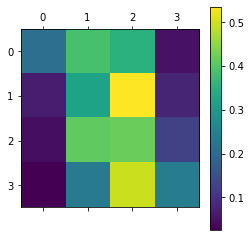

In [150]:
single_market = product_data['market_ids'] == 0
plt.colorbar(plt.matshow(diversions[single_market]))

In [125]:
T, J = 600, 4
diversion_ratios.reshape((T, J, J)).mean(axis=0)

array([[0.25223337, 0.25478478, 0.2492879 , 0.24369395],
       [0.24526826, 0.24206389, 0.26498798, 0.24767987],
       [0.24258774, 0.25069089, 0.24345399, 0.26326738],
       [0.25047845, 0.24528188, 0.24005981, 0.26417986]])

bootstrapped_results = updated_results.bootstrap(draws=100, seed=0)
bounds = np.percentile(
    bootstrapped_results.extract_diagonal_means(
        bootstrapped_results.compute_diversion_ratios()
    ),
    q=[10, 90],
    axis=0
)
table = pd.DataFrame(index=problem.unique_market_ids, data={
    'Lower Bound': bounds[0].flatten(),
    'Mean Own Elasticity': means.flatten(),
    'Upper Bound': bounds[1].flatten()
})
table.round(2).head()

-------

# Part 5 (Q10, Q11, Q12, Q13, Q14, Q15)

# Q10. 

* Assume that firm 1 and 2 decided to get merged. Before the merge, firm 1's price came from the following Bertrand-Nash first order condition: 

$$\frac{\partial \pi_1}{\partial p_1} = s_1(p) + (p_1 - mc_1)\frac{\partial s_1(p)}{\partial p_1} \overset{!}{=} 0
$$

* However, after the merger, profit of firm 2 is internalized to firm 1 as follows:

$$\frac{\partial (\pi_1 + \pi_2)}{\partial p_1} = s_1(p) + (p_1 - mc_1)\frac{\partial s_1(p)}{\partial p_1} + \underbrace{(p_2 - mc_2)\frac{\partial s_2(p)}{\partial p_1}}_{internalized}\overset{!}{=} 0
$$

* Hence, if increase in $p_1$ elevates $s_2$, firm 1 has an incentive to increase its price level $p_1$ after the merge. If the two products 1 and 2 were a close substitutes, increase in $p_1$ is more feasible.  

* After the price increase of firm 1, firm 3 and firm 4 could have incentive to increase their price levels. Because, increase in $p_1$ could elevate their market shares and with the increased market share each of the firm 3 and firm 4 has an incentive to increase their price levels following their own Bertrand-Nash first order conditions.

# Q11. 

In [47]:
costs = updated_results.compute_costs()
hhi = updated_results.compute_hhi()
profits = updated_results.compute_profits(costs=costs)
cs = updated_results.compute_consumer_surpluses()

Computing marginal costs ...
Finished after 00:00:00.

Computing HHI ...
Finished after 00:00:00.

Computing profits ...
Finished after 00:00:00.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.



In [48]:
product_data['merger_ids'] = product_data['firm_ids'].replace(2, 1)
changed_prices = updated_results.compute_prices(firm_ids=product_data['merger_ids'],
                                                costs=costs)
product_data['price_merge1'] = changed_prices
product_data['price_increase1'] = product_data['price_merge1'] - product_data['prices']
product_data[['prices', 'price_merge1', 'price_increase1']]

Solving for equilibrium prices ...
Finished after 00:00:01.



,prices,price_merge1,price_increase1
0,3.549269,3.842045,0.292776
1,2.455426,2.650153,0.194727
2,2.870541,3.002023,0.131482
3,3.181449,3.446734,0.265284
4,2.663971,2.928279,0.264308
...,...,...,...
595,2.110721,2.123580,0.012859
596,3.353164,3.362969,0.009804
597,3.353391,3.358798,0.005407
598,2.657853,2.679459,0.021606


In [49]:
print("minimum price increase: ",np.array(product_data['price_increase1']).min())
print("average price increase: ",np.array(product_data['price_increase1']).mean())
print("maximum price increase: ",np.array(product_data['price_increase1']).max())

minimum price increase:  8.196556757322782e-06
average price increase:  0.10600311085490788
maximum price increase:  1.830842904996429


as predicted from the question 10, price is increased for all firms after the merge between firm 1 and 2.

Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.



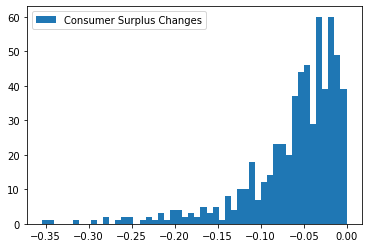

In [50]:
changed_cs1 = updated_results.compute_consumer_surpluses(changed_prices)
plt.hist(changed_cs1 - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

In [62]:
(changed_cs1 - cs).sum() 

-36.518466455259784

# Q12.

In [51]:
product_data['merger_ids2'] = product_data['firm_ids'].replace(3, 1)
changed_prices2 = updated_results.compute_prices(firm_ids=product_data['merger_ids2'],
                                                 costs=costs)
product_data['price_merge2'] = changed_prices2
product_data['price_increase2'] = product_data['price_merge2'] - product_data['prices']
product_data[['prices', 'price_merge2', 'price_increase2']]

Solving for equilibrium prices ...
Finished after 00:00:01.



,prices,price_merge2,price_increase2
0,3.549269,3.853279,0.304010
1,2.455426,2.491563,0.036137
2,2.870541,2.882034,0.011493
3,3.181449,3.297320,0.115870
4,2.663971,2.908335,0.244364
...,...,...,...
595,2.110721,2.130435,0.019714
596,3.353164,3.356466,0.003301
597,3.353391,3.359419,0.006029
598,2.657853,2.659854,0.002001


In [52]:
print("minimum price increase: ",np.array(product_data['price_increase2']).min())
print("average price increase: ",np.array(product_data['price_increase2']).mean())
print("maximum price increase: ",np.array(product_data['price_increase2']).max())

minimum price increase:  3.283485683036602e-05
average price increase:  0.06302816826069384
maximum price increase:  0.6680451223101582


Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.



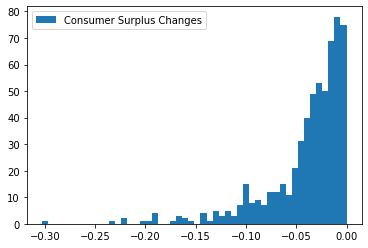

In [53]:
changed_cs2 = updated_results.compute_consumer_surpluses(changed_prices2)
plt.hist(changed_cs2 - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

In [63]:
(changed_cs2 - cs).sum() 

-23.81873630443517

* Welfare change under merger case of Q11 is -36.518 whereas the change in welfare from the merger case of Q12 is -23.818. In other words, the negative impact on consumers is more severe under the merge between firm 1 and firm 2. 

* This is because the internalized value from the merger is greater in the case under Q10. So the merged firm has a more room to increase their price level. Which will lead to the increase in the price levels of the other two firms. 

# Q13.

* Recall the firm 1's Bertrand Nash first order condition after merging with firm 2.  

$$\frac{\partial (\pi_1 + \pi_2)}{\partial p_1} = s_1(p) + \overbrace{\underbrace{(p_1 - mc_1)}_{(1)}\underbrace{\frac{\partial s_1(p)}{\partial p_1}}_{(a)} + \underbrace{(p_2 - mc_2)}_{(2)}\underbrace{\frac{\partial s_2(p)}{\partial p_1}}_{(b)}}^{V}\overset{!}{=} 0
$$

* With the efficiency from merge, terms (1) and (2) will increase. The magnitudes of the increases depend on the firms' initial marginal costs $mc_1$ and $mc_2$. For the simplicity, let's assume that $mc_1 = mc_2$. Holding the price level fixed (will elaborate more on the price level later on), (1) and (2) will increase by the same amount. However, we know that (a) + (b) < 0. Therefore, with the efficiency from merge, $V$ will have more negative value than before.  

* Hence, to meet the first order condition, the merged firm(= firm1 + firm2) has an incentive to increase $s_1(p)$ and to decrease term (1) which can be achieved by lowering the price $p_1$. This logic applies to the firm 2 in the same manner. Therefore, reduction in costs from a merge could decrease the merged firms' price levels. 


$$\frac{\partial \pi_3}{\partial p_3} = \underbrace{s_3(p)}_{A} + (p_3 - mc_3)\underbrace{\frac{\partial s_3(p)}{\partial p_3}}_{B} \overset{!}{=} 0
$$
* When the merged firm decreases its price levels, the other two firms could have incentives to lower their prices to meet their first order conditions. (This depends on the values of A and B) 

* Hence, a merger-specific reduction in marginal cost could mean that a merger is welfare enhancing.



# Q14.  Q15.

In [54]:
merger_costs = costs.copy()
merger_costs[product_data.merger_ids==1] = 0.85*merger_costs[product_data.merger_ids==1]

In [55]:
changed_prices3 = updated_results.compute_prices(firm_ids=product_data['merger_ids'],
                                                costs=merger_costs)
product_data['price_cost_reduction'] = changed_prices3
product_data['price_increase3'] = product_data['price_cost_reduction'] - product_data['prices']
product_data[['prices', 'price_cost_reduction', 'price_increase3']]

Solving for equilibrium prices ...
Finished after 00:00:01.



,prices,price_cost_reduction,price_increase3
0,3.549269,3.483444,-0.065825
1,2.455426,2.501265,0.045839
2,2.870541,2.781338,-0.089202
3,3.181449,3.190805,0.009356
4,2.663971,2.732474,0.068503
...,...,...,...
595,2.110721,2.105786,-0.004936
596,3.353164,3.359481,0.006317
597,3.353391,3.356780,0.003390
598,2.657853,2.648422,-0.009431


In [56]:
print("minimum price increase: ",np.array(product_data['price_increase3']).min())
print("average price increase: ",np.array(product_data['price_increase3']).mean())
print("maximum price increase: ",np.array(product_data['price_increase3']).max())

minimum price increase:  -0.38773413156467296
average price increase:  -0.0030939991438001923
maximum price increase:  1.7522728507120466


Computing consumer surpluses with the equation that assumes away nonlinear income effects ...
Finished after 00:00:00.



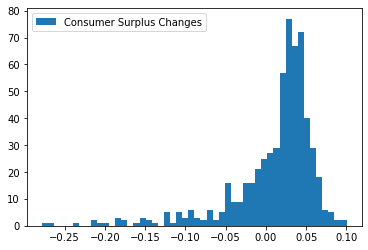

In [57]:
changed_cs3 = updated_results.compute_consumer_surpluses(changed_prices3)
plt.hist(changed_cs3 - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

In [68]:
(changed_cs3 - cs).sum()

6.346580269266329

* As predicted from the Q13, with reduction in costs from merge, consumer welfare increased by 6.346 compared to the previous economy.